In [1]:
import os
import json
from openai import AzureOpenAI
from typing import List, Dict
from dotenv import load_dotenv

### To save explanation and results 

In [10]:
import json
import os
from typing import List, Dict
import google.generativeai as genai
import re
from google.cloud import aiplatform

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-2.5-flash")

# # using vertex ai
# aiplatform.init(project="aiha-467522", location="us-west2-a")
# model = aiplatform.GenerativeModel("gemini-2.5-flash")

generation_config = {
    "seed": 123
}

# Load and parse chunk data from JSON file
def load_chunks_from_file(chunk_path: str) -> List[Dict[str, str]]:
    with open(chunk_path, "r", encoding="utf-8") as f:
        data = json.load(f)
     # If data is a list, return it directly; if it's a dict, return its values as a list.
    if isinstance(data, list):
        return data
    return list(data.values())

# Format exhibit chunks
def format_chunks(chunks: List[Dict[str, str]]) -> str:
    return "\n\n".join(
        f"Chunk ID: {chunk['id']}\nText: {chunk['text']}" for chunk in chunks
    )

# Build prompt for Gemini
def create_prompt(query: str, chunks: List[Dict[str, str]]) -> str:
    return f"""
You are an expert Chinese art historian evaluating the relevance of museum exhibit texts to a visitor’s interests.

## Visitor Interests:
{query}

For each exhibit chunk provided below, rate how relevant the retrieved chunks are based on the alignment with the user's interests. Explain your reasoning briefly.

1 = completely irrelevant, not aligned with any interests (title pages or biligraphies should be rated 1)
3 = moderately relevant, aligns with several interests
5 = highly relevant, perfectly aligned with all interests

Only output the result in **valid JSON** using this format:
[
  {{
    "chunk_id": "string",
    "score": int,
    "reason": "string"
  }},
  ...
]

## Exhibit Chunks:
{format_chunks(chunks)}
""".strip()

# Extract JSON content from Gemini output
def extract_json(text: str) -> List[Dict]:
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        # Try to find JSON block inside the text
        match = re.search(r"\[\s*{.*?}\s*]", text, re.DOTALL)
        if match:
            try:
                return json.loads(match.group(0))
            except json.JSONDecodeError:
                pass
        print("❌ Could not extract valid JSON from the response.")
        return []

# Evaluate and save results
def evaluate_chunks(query: str, chunk_path: str, save_dir: str) -> str:
    chunks = load_chunks_from_file(chunk_path)
    prompt = create_prompt(query, chunks)

    try:
        response = model.generate_content(prompt, 
                                          generation_config={
                                              "temperature": 0.0, 
                                              "top_p": 0.0,
                                          })
        full_response = response.text.strip()
        result = extract_json(full_response)
    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        return ""

    if not result:
        print("❌ No valid results to save.")
        return ""

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Construct output file path
    filename = f"evaluation_result.json"
    save_path = os.path.join(save_dir, filename)

    # Save the result to file
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2, ensure_ascii=False)

    print(f"✅ Results saved to: {save_path}")
    return save_path

In [ ]:
# query = "I'm interested in iron cermanics artifacts, from the qing period, originating in east asia. I also like auspicious symbolism."


evaluate_chunks(query, "output/Objectifying_China/tagged/test_retriever/preference2_results.json", "output/Objectifying_China/tagged/test_retriever")

✅ Results saved to: output/Objectifying_China/tagged/test_retriever/evaluation_result.json


'output/Objectifying_China/tagged/test_retriever/evaluation_result.json'

In [9]:
import json

input_file = "output/Objectifying_China/tagged/test_retriever/evaluation_result.json"
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

total_score = 0
for item in data: 
    total_score += item["score"]

print(f"mean score: {total_score / len(data)}")


mean score: 2.1333333333333333


### Tests

In [1]:
from classes.survey import SurveyResponse, Preferences
from query_rewritter import generate_human_query
from retriever import DefaultRetriever

response1 = SurveyResponse(
    major="Computer Science",
    age_group="8-10",
    class_subject="Music",
    exhibits=["objectifying_china"],
    tour_length_minutes=60,
    time_period=["ming"],
    materiality=["porcelain"],
    themes=["nature"],
    additional_interests=["auspicious symbolism"],
    region=[""], 
    colour=[""],
    purpose=[""],
    additional_notes=["rare artifacts"]
)

preferences1 = Preferences(
    exhibits=response1.exhibits,
    time_period=response1.time_period,
    materiality=response1.materiality,
    region=response1.region,
    colour=response1.colour,
    purpose=response1.purpose,
    themes=response1.themes,
    additional_interests=response1.additional_interests
)

response2 = SurveyResponse(
    major="Primary",
    age_group="10-12",
    class_subject="Art",
    exhibits=["objectifying_china"],
    tour_length_minutes=75,
    time_period=[""],
    materiality=["stoneware"],
    themes=[""],
    additional_interests=["thailand ceramics"],
    region=["southeast_asia"],
    colour=["green", "celadon"],
    purpose=["functional"],
    additional_notes=["students will be sketching"]
)

preferences2 = Preferences(
    exhibits=response2.exhibits,
    time_period=response2.time_period,
    materiality=response2.materiality,
    region=response2.region,
    colour=response2.colour,
    purpose=response2.purpose,
    themes=response2.themes,
    additional_interests=response2.additional_interests
)

response3 = SurveyResponse(
    major="Literature",
    age_group="12-14",
    class_subject="History",
    exhibits=["objectifying_china"],
    tour_length_minutes=90,
    time_period=["qing"],
    materiality=["porcelain"],
    themes=["religious"],
    additional_interests=["buddhist symbolism in ceramics"],
    region=[],
    colour=[],
    purpose=["ritual"],
    additional_notes=["focus on connections between religion and material culture"]
)

preferences3 = Preferences(
    exhibits=response3.exhibits,
    time_period=response3.time_period,
    materiality=response3.materiality,
    region=response3.region,
    colour=response3.colour,
    purpose=response3.purpose,
    themes=response3.themes,
    additional_interests=response3.additional_interests
)

response4 = SurveyResponse(
    major="Astronomy",
    age_group="13-15",
    class_subject="Geography",
    exhibits=["objectifying_china"],
    tour_length_minutes=60,
    time_period=[],
    materiality=["porcelain"],
    themes=["nature", "symbolism"],
    additional_interests=["trade and export routes"],
    region=["southeast_asia", "dehua"],
    colour=[""],
    purpose=["export"],
    additional_notes=["interested in global trade of ceramics"]
)

preferences4 = Preferences(
    exhibits=response4.exhibits,
    time_period=response4.time_period,
    materiality=response4.materiality,
    region=response4.region,
    colour=response4.colour,
    purpose=response4.purpose,
    themes=response4.themes,
    additional_interests=response4.additional_interests
)

response5 = SurveyResponse(
    major="History",
    age_group="14-16",
    class_subject="History",
    exhibits=["objectifying_china"],
    tour_length_minutes=45,
    time_period=[],
    materiality=["porcelain"],
    themes=[""],
    additional_interests=["discuss production factories"],
    region=["europe"],
    colour=[],
    purpose=[],
    additional_notes=["students preparing for a storytelling project"]
)

preferences5 = Preferences(
    exhibits=response5.exhibits,
    time_period=response5.time_period,
    materiality=response5.materiality,
    region=response5.region,
    colour=response5.colour,
    purpose=response5.purpose,
    themes=response5.themes,
    additional_interests=response5.additional_interests
)

query1 = generate_human_query(preferences1)
query2 = generate_human_query(preferences2)
query3 = generate_human_query(preferences3)
query4 = generate_human_query(preferences4)
query5 = generate_human_query(preferences5)


/Users/kellyzhu/anaconda3/envs/aiha/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from classes.survey import SurveyResponse, Preferences
from query_rewritter import generate_human_query
from retriever import DefaultRetriever

response6 = SurveyResponse(
    major="Engineering",
    age_group="16-18",
    class_subject="Physics",
    exhibits=["objectifying_china"],
    tour_length_minutes=90,
    time_period=["song"],  # Valid time period
    materiality=["porcelain"],  # Valid material
    themes=["nature"],  # Valid theme
    additional_interests=["animals"],
    region=[""],  # Valid region
    colour=["celadon"],  # Valid colour
    purpose=[""],  # Valid purpose
    additional_notes=["focused on the development of ceramic technology"]
)

preferences6 = Preferences(
    exhibits=response6.exhibits,
    time_period=response6.time_period,
    materiality=response6.materiality,
    region=response6.region,
    colour=response6.colour,
    purpose=response6.purpose,
    themes=response6.themes,
    additional_interests=response6.additional_interests
)

response7 = SurveyResponse(
    major="Philosophy",
    age_group="18-22",
    class_subject="Cultural Studies",
    exhibits=["objectifying_china"],
    tour_length_minutes=120,
    time_period=["qing"],  # Valid time period
    materiality=[""],  # Valid material
    themes=["symbolism", "religious"],  # Valid themes
    additional_interests=["confucian symbolism"],
    region=["east_asia"],  # Valid region
    colour=[""],  # Valid colour
    purpose=["ritual"],  # Valid purpose
    additional_notes=["focus on the relationship between philosophy and material culture"]
)

preferences7 = Preferences(
    exhibits=response7.exhibits,
    time_period=response7.time_period,
    materiality=response7.materiality,
    region=response7.region,
    colour=response7.colour,
    purpose=response7.purpose,
    themes=response7.themes,
    additional_interests=response7.additional_interests
)

response8 = SurveyResponse(
    major="Anthropology",
    age_group="12-14",
    class_subject="Social Studies",
    exhibits=["objectifying_china"],
    tour_length_minutes=50,
    time_period=[""],  # Valid time period
    materiality=[""],  # Valid material
    themes=[""],  # Valid theme
    additional_interests=[""],
    region=[""],  # Valid region
    colour=[""],  # Valid colour
    purpose=["commission"],  # Valid purpose
    additional_notes=["students will be analyzing social functions of jade"]
)

preferences8 = Preferences(
    exhibits=response8.exhibits,
    time_period=response8.time_period,
    materiality=response8.materiality,
    region=response8.region,
    colour=response8.colour,
    purpose=response8.purpose,
    themes=response8.themes,
    additional_interests=response8.additional_interests
)

response9 = SurveyResponse(
    major="Art History",
    age_group="18-22",
    class_subject="Art History",
    exhibits=["objectifying_china"],
    tour_length_minutes=100,
    time_period=["ming"],  # Valid time period
    materiality=[""],  # Valid material
    themes=[""],  # Valid theme
    additional_interests=["dragons"],
    region=[""],  # Valid region
    colour=["wucai/five_colour", "sancai/three_colour"],  # Valid colour
    purpose=["artistic expression"],  # Valid purpose
    additional_notes=["analysis of the aesthetic qualities in ceramics"]
)

preferences9 = Preferences(
    exhibits=response9.exhibits,
    time_period=response9.time_period,
    materiality=response9.materiality,
    region=response9.region,
    colour=response9.colour,
    purpose=response9.purpose,
    themes=response9.themes,
    additional_interests=response9.additional_interests
)

response10 = SurveyResponse(
    major="Sociology",
    age_group="16-18",
    class_subject="Sociology",
    exhibits=["objectifying_china"],
    tour_length_minutes=70,
    time_period=["ming"],  # Valid time period
    materiality=[""],  # Valid material
    themes=[],  # Valid themes
    additional_interests=[""],
    region=[""],  # Valid region
    colour=["blue/cobalt"],  # Valid colour
    purpose=["decoration", "export"],  # Valid purpose
    additional_notes=["discussion of how lacquerware reflects social stratification"]
)

preferences10 = Preferences(
    exhibits=response10.exhibits,
    time_period=response10.time_period,
    materiality=response10.materiality,
    region=response10.region,
    colour=response10.colour,
    purpose=response10.purpose,
    themes=response10.themes,
    additional_interests=response10.additional_interests
)

query6 = generate_human_query(preferences6)
query7 = generate_human_query(preferences7)
query8 = generate_human_query(preferences8)
query9 = generate_human_query(preferences9)
query10 = generate_human_query(preferences10)


In [3]:
import numpy as np
from itertools import product

step = 1/3
grid_weight = [
    {'dense_weight': d, 'sparse_weight': s, 'metadata_weight': m}
    for d, s, m in product(np.arange(0, 1.1, step), repeat=3)
    if np.isclose(d + s + m, 1.0)
]
grid_weight

[{'dense_weight': 0.0, 'sparse_weight': 0.0, 'metadata_weight': 1.0},
 {'dense_weight': 0.0,
  'sparse_weight': 0.3333333333333333,
  'metadata_weight': 0.6666666666666666},
 {'dense_weight': 0.0,
  'sparse_weight': 0.6666666666666666,
  'metadata_weight': 0.3333333333333333},
 {'dense_weight': 0.0, 'sparse_weight': 1.0, 'metadata_weight': 0.0},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.0,
  'metadata_weight': 0.6666666666666666},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.3333333333333333,
  'metadata_weight': 0.3333333333333333},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.6666666666666666,
  'metadata_weight': 0.0},
 {'dense_weight': 0.6666666666666666,
  'sparse_weight': 0.0,
  'metadata_weight': 0.3333333333333333},
 {'dense_weight': 0.6666666666666666,
  'sparse_weight': 0.3333333333333333,
  'metadata_weight': 0.0},
 {'dense_weight': 1.0, 'sparse_weight': 0.0, 'metadata_weight': 0.0}]

In [8]:
len(grid_weight)
# grid_weight

10

In [16]:
grid_weight = grid_weight[]
len(grid_weight)

8

In [11]:
import os
import json
import re
from typing import List, Dict
import numpy as np
import google.generativeai as genai
from statistics import median, mode, StatisticsError

genai.configure(api_key=os.environ.get("GEMINI_API_KEY2"))
model = genai.GenerativeModel("gemini-2.5-flash")

# Format exhibit chunks for prompt
def format_chunks(chunks: List[Dict[str, str]]) -> str:
    return "\n\n".join(
        f"Chunk ID: {chunk['id']}\nText: {chunk['text']}" for chunk in chunks
    )

# Build prompt for Gemini
def create_prompt(query: str, chunks: List[Dict[str, str]]) -> str:
    return f"""
You are an expert Chinese art historian evaluating the relevance of museum exhibit texts to a visitor’s interests. You are a strict and consistent judge. Be deterministic. Always apply the same criteria to similar inputs.

## Visitor Interests:
{query}

For each exhibit chunk provided below, rate how relevant the retrieved chunks are based on the alignment with the user's interests.

1 = completely irrelevant, not aligned with any interests (title pages, very short pages, or biligraphies should be rated 1)
2 = somewhat relevant, aligns with some interests
3 = moderately relevant, aligns with several interests
4 = relevant, aligns with most interests
5 = highly relevant, perfectly aligned with all interests

Only output the result in **valid JSON** using this format:
[
  {{
    "chunk_id": "string",
    "score": int
  }},
  ...
]

## Exhibit Chunks:
{format_chunks(chunks)}
""".strip()

# Extract JSON list from Gemini output
def extract_json(text: str) -> List[Dict]:
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        match = re.search(r"\[\s*{.*?}\s*]", text, re.DOTALL)
        if match:
            try:
                return json.loads(match.group(0))
            except json.JSONDecodeError:
                pass
        print("❌ Could not extract valid JSON from the response.")
        return []

# Evaluate and return only the mean score
def evaluate_and_summarize(query: str, chunks: List[Dict[str, str]], temp=0) -> float:
    prompt = create_prompt(query, chunks)

    try:
        response = model.generate_content(prompt, 
                                          generation_config={
                                              "temperature": temp, 
                                            #   "top_p": 0.0,
                                          })
        full_response = response.text.strip()
        results = extract_json(full_response)
    except Exception as e:
        print(f"❌ Error during Gemini evaluation: {e}")
        return 0.0

    if not results:
        print("❌ No valid results returned.")
        return 0.0

    scores = [item['score'] for item in results if isinstance(item.get('score'), int)]

    if not scores:
        print("⚠️ No valid scores found in results.")
        return 0.0

    return float(np.mean(scores))

# # Evaluate and return the average score over 3 temperature settings
# def evaluate_and_summarize(query: str, chunks: List[Dict[str, str]]) -> float:
#     prompt = create_prompt(query, chunks)
#     temperatures = [0.0, 0.2, 0.4]
#     all_scores = []

#     for temp in temperatures:
#         try:
#             response = model.generate_content(
#                 prompt,
#                 generation_config={
#                     "temperature": temp,
#                     # "top_p": 1.0  # optionally enable or tune
#                 }
#             )
#             full_response = response.text.strip()
#             results = extract_json(full_response)

#             if not results:
#                 print(f"❌ No valid results at temperature {temp}")
#                 continue

#             scores = [item['score'] for item in results if isinstance(item.get('score'), int)]

#             if not scores:
#                 print(f"⚠️ No valid scores found in results at temperature {temp}")
#                 continue

#             mean_score = float(np.mean(scores))
#             all_scores.append(mean_score)

#         except Exception as e:
#             print(f"❌ Error during Gemini evaluation at temperature {temp}: {e}")
#             continue

#     if not all_scores:
#         print("❌ All evaluations failed.")
#         return 0.0

#     return float(np.mean(all_scores))


In [36]:
query=generate_human_query(preferences6)
query

"I'm interested in blue/cobalt porcelain artifacts, from the qing period, originating in jingdezhen_kilns, with themes of technique. I also like animals."

In [3]:
generate_human_query(preferences9)

"I'm interested in wucai/five_colour, sancai/three_colour  artifacts, from the ming period, originating in , used for artistic expression, with themes of . I also like dragons."

In [2]:
retriever = DefaultRetriever()
sample_results = retriever._retrieve_with_text(
            query=generate_human_query(preferences9),
            tags=preferences9,
            dense_weight=0.4,
            sparse_weight=0.4,
            tag_weight=0.3, 
            k=10
        )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


<class 'list'>
{
  "id": "z9xpyepf",
  "text": "Like wucai, doucai (\u2018fitted-colour\u2019) porcelains are decorated with a combination of underglaze blue and overglaze enamels. However, while on wucai porcelain underglaze dark blue is applied in bold washes to complement strong overglaze colours, usually within outlines in red, brown or black, doucai porcelain features pale enamel washes with outlines in soft underglaze blue. Developed during the reign of the Xuande emperor, the technique was perfected in the Chenghua period. It has been used to great effect on this bowl to depict mandarin ducks in a lotus pond, framed by a band of stylised, possibly Sanskrit, characters on the rim. Since they were mistakenly thought to mate for life, pairs of mandarin ducks are an auspicious symbol for a happy marriage in China. When accompanied by lotuses, homophonous in Chinese with the word for harmony (he), they may also be interpreted as expressing the wish for many sons, and ceramics pairing

In [38]:
output = "output/Objectifying_China/tagged/test_retriever/preference6_results.json"
os.makedirs(os.path.dirname(output), exist_ok=True)

with open(output, "w", encoding="utf-8") as json_file:
    json.dump(sample_results, json_file, indent=4)

In [49]:
evaluate_chunks(query, "output/Objectifying_China/tagged/test_retriever/preference6_results.json", "output/Objectifying_China/tagged/test_retriever")

✅ Results saved to: output/Objectifying_China/tagged/test_retriever/evaluation_result.json


'output/Objectifying_China/tagged/test_retriever/evaluation_result.json'

In [17]:
grid_weight = grid_weight[3:10]

In [18]:
# list_of_preferences = [preferences1, preferences2, preferences3, preferences4, preferences5, preferences6, preferences7, preferences8, preferences9, preferences10]
list_of_preferences = [preferences1, preferences2, preferences3, preferences4, preferences5]

retriever = DefaultRetriever()

score_results = []

for weight in grid_weight:
    preference_score = []
    for preferences in list_of_preferences:
        results = retriever._retrieve_with_text(
            query=generate_human_query(preferences),
            tags=preferences,
            dense_weight=weight['dense_weight'],
            sparse_weight=weight['sparse_weight'],
            tag_weight=weight['metadata_weight'], 
            k=5
        )

        llm_score = evaluate_and_summarize(
            generate_human_query(preferences), 
            results
        )
        preference_score.append(llm_score)
        
    score_results.append({"dense_weight": weight['dense_weight'],
                    "sparse_weight": weight['sparse_weight'],
                    "metadata_weight": weight['metadata_weight'],
                    "min_score": round(float(np.min(preference_score)), 2),
                    "max_score": round(float(np.max(preference_score)), 2),
                    "mean_score": round(float(np.mean(preference_score)), 2), 
                    "median_score": round(float(median(preference_score)), 2),
                    "std_score": round(float(np.std(preference_score, ddof=0)), 2), 
                    "raw_scores": preference_score
                    })
        
# print(score_results)

In [19]:
score_results

[{'dense_weight': 0.0,
  'sparse_weight': 1.0,
  'metadata_weight': 0.0,
  'min_score': 2.6,
  'max_score': 4.0,
  'mean_score': 3.0,
  'median_score': 2.8,
  'std_score': 0.51,
  'raw_scores': [2.8, 4.0, 2.8, 2.8, 2.6]},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.0,
  'metadata_weight': 0.6666666666666666,
  'min_score': 3.0,
  'max_score': 4.2,
  'mean_score': 3.76,
  'median_score': 4.0,
  'std_score': 0.48,
  'raw_scores': [4.2, 4.2, 3.0, 4.0, 3.4]},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.3333333333333333,
  'metadata_weight': 0.3333333333333333,
  'min_score': 2.8,
  'max_score': 4.2,
  'mean_score': 3.6,
  'median_score': 3.6,
  'std_score': 0.49,
  'raw_scores': [3.6, 4.2, 2.8, 4.0, 3.4]},
 {'dense_weight': 0.3333333333333333,
  'sparse_weight': 0.6666666666666666,
  'metadata_weight': 0.0,
  'min_score': 2.8,
  'max_score': 4.0,
  'mean_score': 3.4,
  'median_score': 3.6,
  'std_score': 0.44,
  'raw_scores': [3.0, 4.0, 2.8, 3.6, 3.6]},
 {'den

In [18]:
results_so_far = score_results

In [ ]:
retriever = DefaultRetriever()
sample_results = retriever._retrieve_with_text(
            query=generate_human_query(preferences9),
            tags=preferences9,
            dense_weight=0.7,
            sparse_weight=0.3,
            tag_weight=0.3, 
            k=5
        )

sample_results

In [10]:
len(score_results)
# final_results = score_results

10

In [19]:
final_results = results_so_far + score_results
len(final_results)

16

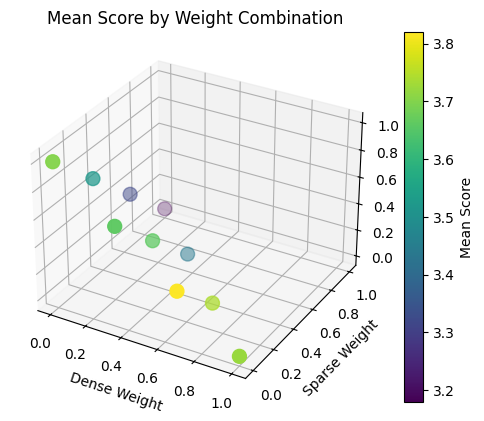

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract values
dense = [r['dense_weight'] for r in score_results]
sparse = [r['sparse_weight'] for r in score_results]
metadata = [r['metadata_weight'] for r in score_results]
mean_score = [r['mean_score'] for r in score_results]

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(dense, sparse, metadata, c=mean_score, cmap='viridis', s=100)

ax.set_xlabel('Dense Weight')
ax.set_ylabel('Sparse Weight')
ax.set_zlabel('Metadata Weight')
plt.title('Mean Score by Weight Combination')

# Colorbar to show mean_score scale
cb = plt.colorbar(sc)
cb.set_label('Mean Score')

plt.show()


In [13]:
best_config = max(score_results, key=lambda x: x["mean_score"])
print("Best configuration:")
print("Dense Weight:", best_config['dense_weight'])
print("Sparse Weight:", best_config['sparse_weight'])
print("Metadata Weight:", best_config['metadata_weight'])
print("Mean Score:", best_config['mean_score'])

Best configuration:
Dense Weight: 0.6666666666666666
Sparse Weight: 0.0
Metadata Weight: 0.3333333333333333
Mean Score: 3.94


In [22]:
import os, json

output = "output/Objectifying_China/tagged/test_retriever/score_results_fixed_k_10.json"
os.makedirs(os.path.dirname(output), exist_ok=True)

with open(output, "w", encoding="utf-8") as json_file:
    json.dump(final_results, json_file, indent=4)

- k = 5
- n=5
- fixed semantic & lexical retrievers to get top_k=50
- improved test examples
- fixed temp & top_p

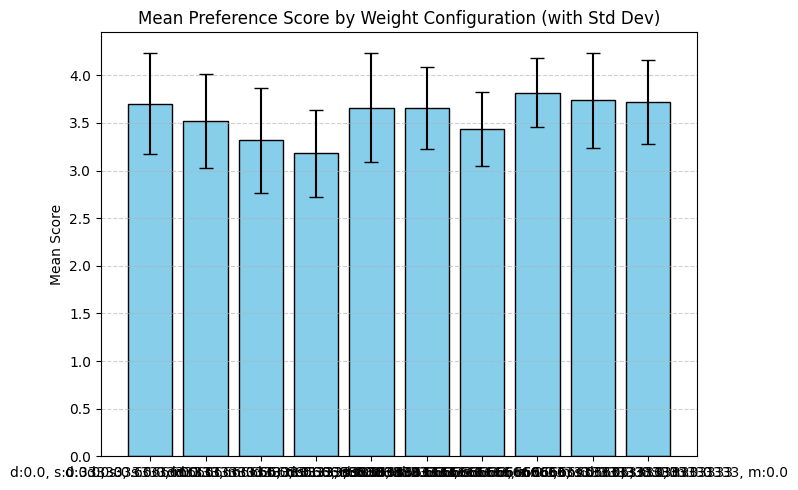

In [9]:
# Labels: Use a readable string for each configuration
labels = [
    f"d:{d['dense_weight']}, s:{d['sparse_weight']}, m:{d['metadata_weight']}"
    for d in score_results
]

# Extract mean and std
mean_scores = [d["mean_score"] for d in score_results]
std_scores = [d["std_score"] for d in score_results]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, mean_scores, yerr=std_scores, capsize=5, color='skyblue', edgecolor='black')
plt.ylabel("Mean Score")
plt.title("Mean Preference Score by Weight Configuration (with Std Dev)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

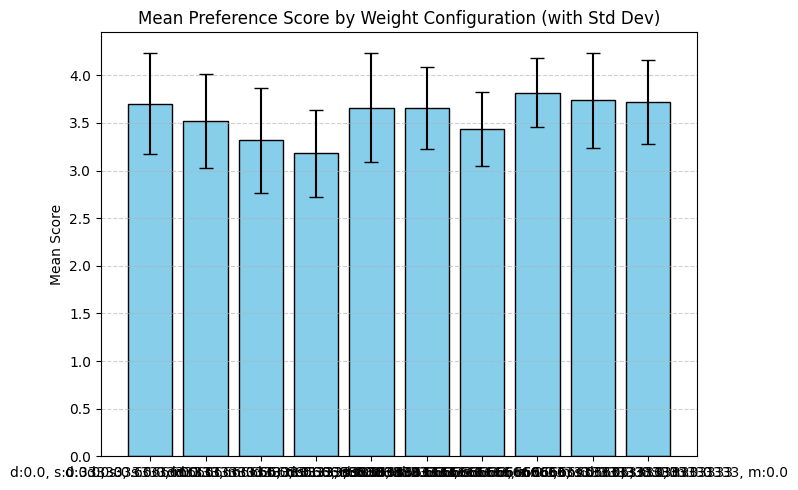

In [ ]:
# k=5, fixed dense retriever 

# Labels: Use a readable string for each configuration
labels = [
    f"d:{d['dense_weight']}, s:{d['sparse_weight']}, m:{d['metadata_weight']}"
    for d in score_results
]

# Extract mean and std
mean_scores = [d["mean_score"] for d in score_results]
std_scores = [d["std_score"] for d in score_results]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, mean_scores, yerr=std_scores, capsize=5, color='skyblue', edgecolor='black')
plt.ylabel("Mean Score")
plt.title("Mean Preference Score by Weight Configuration (with Std Dev)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

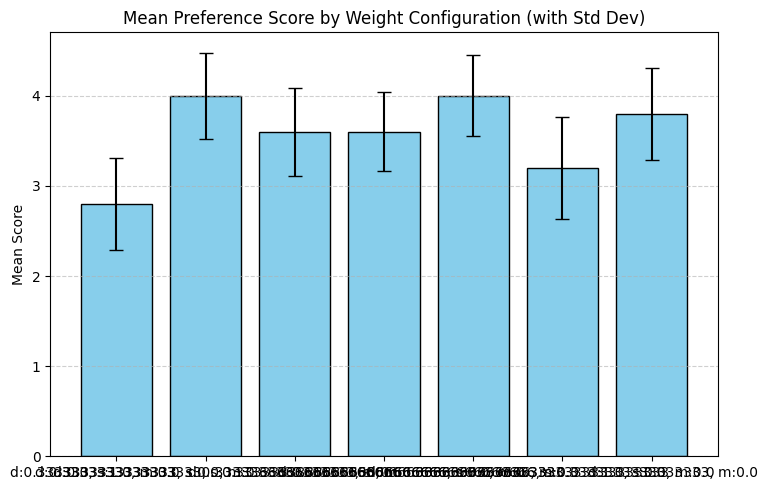

In [20]:
# k=5, fixed dense retriever, rate 1, 3, 5

# Labels: Use a readable string for each configuration
labels = [
    f"d:{d['dense_weight']}, s:{d['sparse_weight']}, m:{d['metadata_weight']}"
    for d in score_results
]

# Extract mean and std
mean_scores = [d["median_score"] for d in score_results]
std_scores = [d["std_score"] for d in score_results]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, mean_scores, yerr=std_scores, capsize=5, color='skyblue', edgecolor='black')
plt.ylabel("Mean Score")
plt.title("Mean Preference Score by Weight Configuration (with Std Dev)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

saved_results = score_results

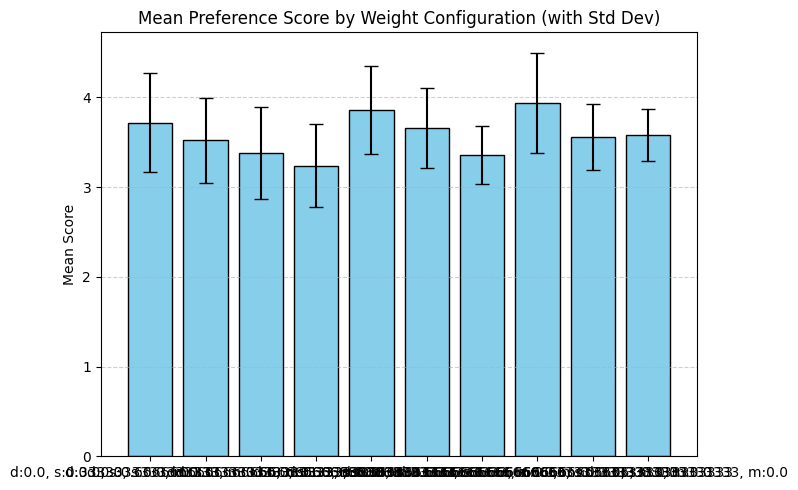

In [15]:
# k=10
# fixed tagging bug
# Labels: Use a readable string for each configuration
labels = [
    f"d:{d['dense_weight']}, s:{d['sparse_weight']}, m:{d['metadata_weight']}"
    for d in score_results
]

# Extract mean and std
mean_scores = [d["mean_score"] for d in score_results]
std_scores = [d["std_score"] for d in score_results]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, mean_scores, yerr=std_scores, capsize=5, color='skyblue', edgecolor='black')
plt.ylabel("Mean Score")
plt.title("Mean Preference Score by Weight Configuration (with Std Dev)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [1]:
from classes.survey import SurveyResponse, Preferences
from query_rewritter import generate_human_query
from retriever import DefaultRetriever


response9 = SurveyResponse(
    major="Art History",
    age_group="18-22",
    class_subject="Art History",
    exhibits=["objectifying_china"],
    tour_length_minutes=100,
    time_period=["ming"],  # Valid time period
    materiality=[""],  # Valid material
    themes=[""],  # Valid theme
    additional_interests=["dragons"],
    region=[""],  # Valid region
    colour=["wucai/five_colour", "sancai/three_colour"],  # Valid colour
    purpose=["artistic expression"],  # Valid purpose
    additional_notes=["analysis of the aesthetic qualities in ceramics"]
)

preferences9 = Preferences(
    exhibits=response9.exhibits,
    time_period=response9.time_period,
    materiality=response9.materiality,
    region=response9.region,
    colour=response9.colour,
    purpose=response9.purpose,
    themes=response9.themes,
    additional_interests=response9.additional_interests
)

SyntaxError: '(' was never closed (retriever.py, line 92)

In [ ]:
from utils import get_number_tag_matches

def search_tags(tags: Preferences, top_k=100):
        """
        Perform a metadata search based on the provided Preferences object.
        
        Args:
            tags: A Preferences object with attributes:
                - time_period: List[str]
                - themes: List[str]
                - exhibits: List[str]
                - art_medium: List[str]
                - additional_interests: List[str]
            top_k: Number of results to return.
            
        Returns:
            List of matching documents from dense_db.
        """
        # Convert the Preferences object to a dictionary.
        tag_dict = tags.__dict__

        # Remove any keys with empty lists.
        tag_dict = {k: v for k, v in tag_dict.items() if v}

        # Dummy vector for metadata filtering (using the dimensions expected by your dense index)
        dummy_vector = np.zeros(512).tolist()

        # Build metadata filter conditions. Each condition looks for documents where a given field contains at least one of the values.
        filter_conditions = []
        for key, values in tag_dict.items():
            filter_conditions.append({key: {"$in": values}})
        
        # Use $or operator so that if any condition matches the document is returned
        metadata_filter = {"$or": filter_conditions} if filter_conditions else {}

        # Perform the semantic search using the dummy vector and only filter by metadata.
        response = self.dense_db.query(
            namespace="umag",
            vector=dummy_vector,
            top_k=top_k,
            include_metadata=True,
            filter=metadata_filter
        )
        
        for i in range(len(response.matches)):
            # normalize the score based on the number of preferences
            response.matches[i]['score'] = get_number_tag_matches(tags, response.matches[i]) / tags.count_preferences()
        
        for item in response.matches:
            if item['id'] == 'jvgpbga6':
                print("tag_results:", item['jvgpbga6'])
                
        # sort matches by tag score
        response.matches.sort(key=lambda match: match['score'], reverse=True)
        return response.matches

In [ ]:
retriever = DefaultRetriever()

sample_results = search_tags(preferences9, top_k=200)

for item in sample_results:
    if item['id'] == 'jvgpbga6':
        print("tag_results:", item['jvgpbga6'])